### Packages and Functions

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import mplhep as hep
import numpy as np
import pandas as pd
import awkward as ak
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()
import torch
import scipy
from scipy.stats import wasserstein_distance

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist
import plot_loss
from torch import optim
from tqdm.notebook import trange

from sklearn.preprocessing import StandardScaler

import zuko
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform, DiagNormal

In [3]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

def build_flow(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=BoxUniform,
                      base_args=[torch.ones(features)*(-1),torch.ones(features)],
                      univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                      passes = 2 if not autoregressive else features)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(features),1*torch.ones(features),
                                                 -1*torch.ones(features), 1*torch.ones(features)))
    
    return flow

def build_flow_gauss(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=DiagNormal,
                      univariate_kwargs={"bound": 10},
                      passes= 2 if not autoregressive else features)
    return flow

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Dataset

In [4]:
#Preparing the dataset
df = ak.from_parquet("all_jets_v6.parquet")

(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

initial_pz = 6500*(generator_info.x1 - generator_info.x2)
initial_E = 6500*(generator_info.x1 + generator_info.x2)

initial_boost = ak.Array(
    {"px": np.zeros_like(initial_pz), "py": np.zeros_like(initial_pz), "pz": initial_pz, "E": initial_E},
    with_name="Momentum4D"
)

#Converting to torch
#Column 1 is pz, column 2 is E
y_cond = np.stack( [ 
    ak.to_numpy(boost_reco.pz, allow_missing=None),
    ak.to_numpy(boost_reco.E, allow_missing=None)]).T

#Rescaling
scaler = StandardScaler()

Y_scaled = torch.from_numpy(scaler.fit_transform(y_cond)).float()

x_target = np.stack( [ 
    ak.to_numpy(generator_info.x1, allow_missing=None),
    ak.to_numpy(generator_info.x2, allow_missing=None)]).T

x_target_torch = torch.from_numpy(x_target).float()

# transform it to pz and E
X = torch.zeros_like(x_target_torch)
X[:,0] = 6500*(x_target_torch[:,0]-x_target_torch[:,1])
X[:,1] = 6500*(x_target_torch[:,0]+x_target_torch[:,1])


X_scaled = torch.from_numpy(scaler.transform(X)).float()

### Training Loop

In [5]:
nepochs = 50
batch_size = 2048
lr_init = 0.0001
N_training_samples = len(Y_scaled)

flow = build_flow_gauss(features=2, ntransforms=4, context=2, hidden_mlp=[32], bins=10, autoregressive=True)
flow = flow.to("cuda")
optimizer = optim.Adam(flow.parameters(), lr=lr_init)

X_scaled = X_scaled.to("cuda")
Y_scaled = Y_scaled.to("cuda")

for e in trange(0, nepochs, desc="Epoch"):
    
    permutation = torch.randperm(N_training_samples).to("cuda")
    t = trange(0, N_training_samples, batch_size, desc="Batch")
    for i in t:
            
        indices = permutation[i:i+batch_size]
        
        optimizer.zero_grad()

        logp_g =  flow(Y_scaled[indices]).log_prob(X_scaled[indices])

        loss =  - logp_g.mean()
        loss.backward()

        optimizer.step()     

        if i % (batch_size *20) == 0:
            t.set_description(f"{loss.item():.4f}", refresh=True)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

In [6]:
flow = flow.cpu()
X_scaled = X_scaled.cpu()
Y_scaled = Y_scaled.cpu()

### Slice Analysis

In [1]:
#TODO: Package it all into a function that takes flow as input, clean everything up
#TODO: Investigate Frobenius norm and Wasserstein distance
#TODO: Git stuff

In [8]:
#Q: Loss function?
#Q: Project registration mystudies?

#features = target, context = conditioning, transforms = layers of bijections, bins = spline nodes, 
# hidden_features = neural network nodes
# autoregressive vs. coupling: autoregressive more expensive, but more expressive (correlation between dimensions)

In [9]:
def select_segments(y, x, pz_range, E_range):
    mask = (y > [pz_range[0], E_range[0]]) & (y < [pz_range[1], E_range[1]])
    mask = mask[:,0]*mask[:,1]
    return y[mask], x[mask]

def compare(y, x, pz_range, E_range):
    y_select, x_select = select_segments(y, x, pz_range, E_range)
    if y_select.shape[0] == 0:
        return None
    Y_select_scaled = torch.from_numpy(scaler.transform(y_select)).float()
    X_select_scaled = torch.from_numpy(scaler.transform(x_select)).float()
    out = flow(Y_select_scaled).sample((1, )).squeeze(0)
    
    print(len(X_select_scaled[:,0].numpy()), len(out[:,0].numpy()))
    
    plt.hist(X_select_scaled[:,0].numpy(), bins=30, histtype="step", label="target", range=(-5, 5))
    plt.hist(out[:,0].numpy(), bins=30, histtype="step", label="generated", range=(-5, 5))
    plt.legend()
    plt.title("pz")
    plt.show()
    
    plt.hist(X_select_scaled[:,1].numpy(), bins=30, histtype="step", label="target", range=(-5, 10))
    plt.hist(out[:,1].numpy(), bins=30, histtype="step", label="generated", range=(-5, 10))
    plt.legend()
    plt.title("E")
    plt.show()
    
    g_pz = scipy.stats.kstest(X_select_scaled[:,0].numpy(), out[:,0].numpy())
    print(g_pz)
    return 0

def goodness(input_flow, y, x, pz_range, E_range):
    y_select, x_select = select_segments(y, x, pz_range, E_range)
    if y_select.shape[0] < 100:
        return (None, None)
    Y_select_scaled = torch.from_numpy(scaler.transform(y_select)).float()
    X_select_scaled = torch.from_numpy(scaler.transform(x_select)).float()
    out = input_flow(Y_select_scaled).sample((1, )).squeeze(0)
    
    pz_goodness = scipy.stats.kstest(X_select_scaled[:,0].numpy(), out[:,0].numpy()).statistic
    E_goodness = scipy.stats.kstest(X_select_scaled[:,1].numpy(), out[:,1].numpy()).statistic
    
    return (pz_goodness, E_goodness)
    
    

328 328


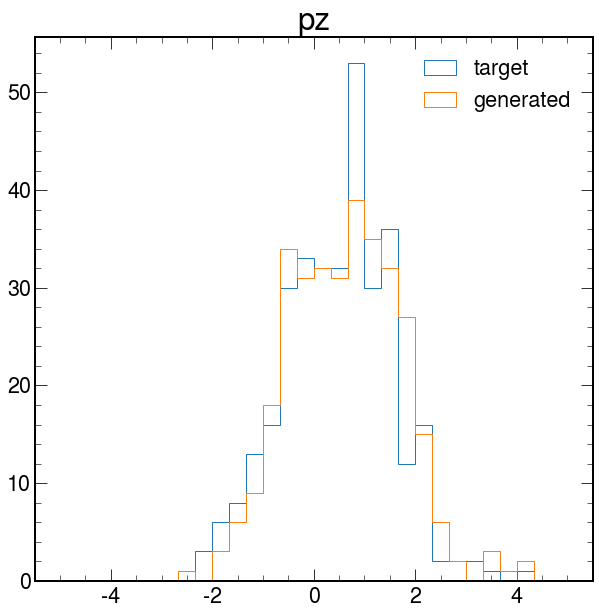

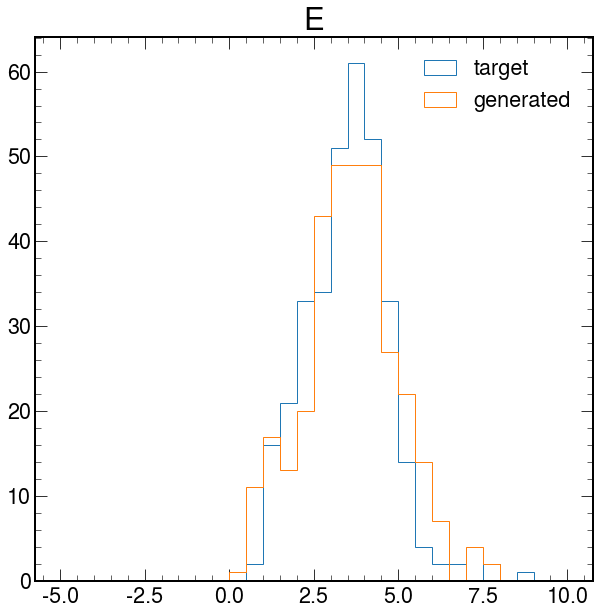

KstestResult(statistic=0.08841463414634146, pvalue=0.15400850143750042)


0

In [10]:
compare(y_cond, X, [0, 600], [3000, 4000])

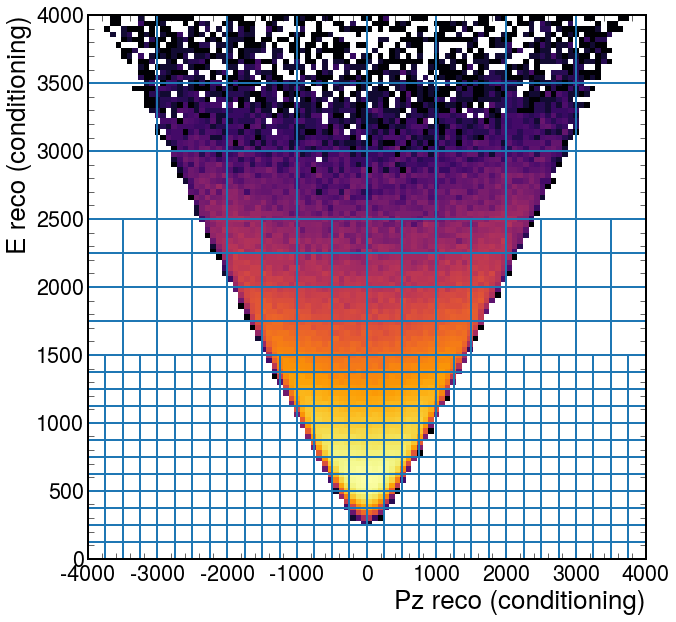

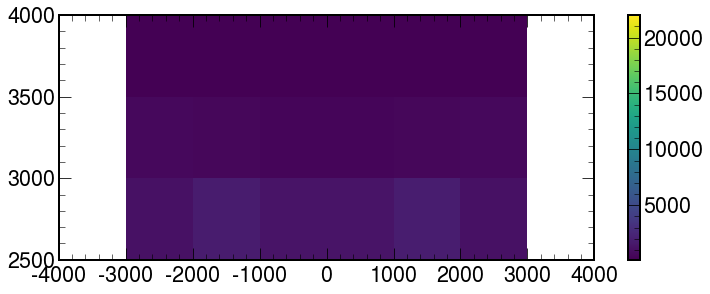

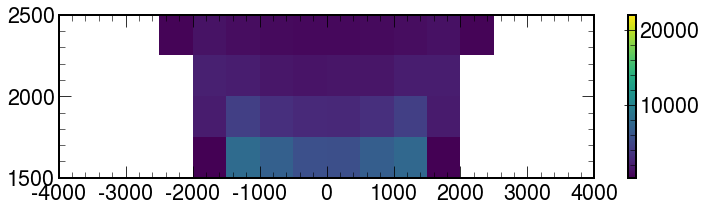

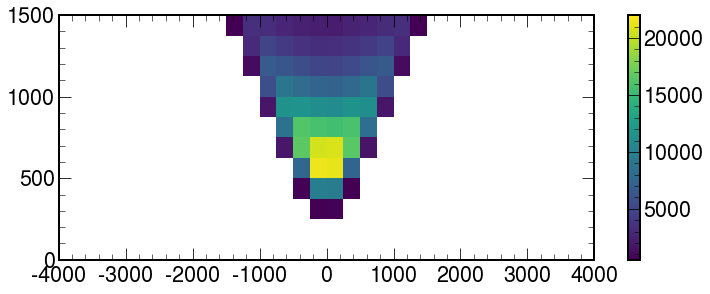

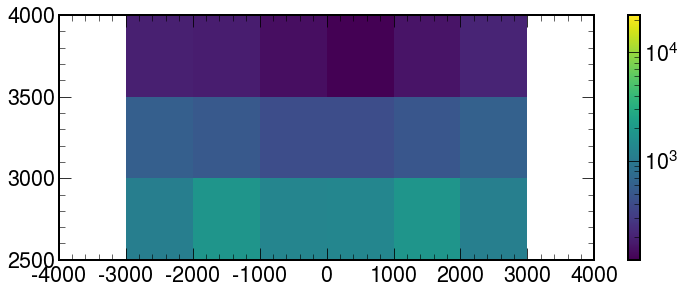

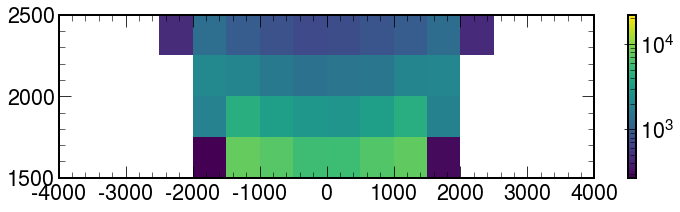

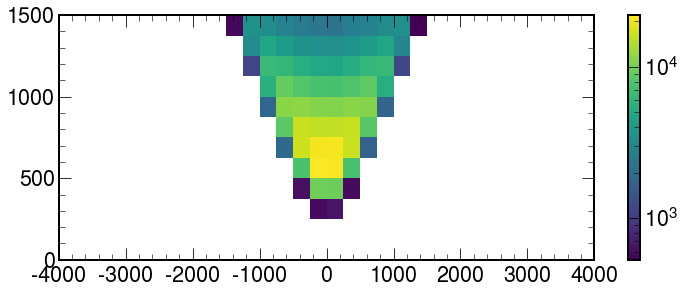

In [11]:
#Dividing reco space

pz_range = [-4000, 4000]
E_range = [0, 1500, 2500, 4000]

seg1_pz = np.linspace(pz_range[0], pz_range[1], 33)
seg1_E = np.linspace(E_range[0], E_range[1], 13)
seg2_pz = np.linspace(pz_range[0], pz_range[1], 17)
seg2_E = np.linspace(E_range[1], E_range[2], 5)
seg3_pz = np.linspace(pz_range[0], pz_range[1], 9)
seg3_E = np.linspace(E_range[2], E_range[3], 4)

plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[100,100], range=[[-4000, 4000], [0,4000]], cmap="inferno", cmin=1, norm=LogNorm())

for i in seg1_pz:
    plt.vlines(seg1_pz, E_range[0], E_range[1])
    plt.hlines(seg1_E, pz_range[0], pz_range[1])
for i in seg2_pz:
    plt.vlines(seg2_pz, E_range[1], E_range[2])
    plt.hlines(seg2_E, pz_range[0], pz_range[1])
for i in seg1_pz:
    plt.vlines(seg3_pz, E_range[2], E_range[3])
    plt.hlines(seg3_E, pz_range[0], pz_range[1])
plt.xlabel("Pz reco (conditioning)")
plt.ylabel("E reco (conditioning)")

plt.show()

plt.figure(figsize=(12, 4.5))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg3_pz, seg3_E], range=[pz_range, [E_range[2], E_range[3]]], cmap="viridis", cmin=100,  norm=Normalize(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg2_pz, seg2_E], range=[pz_range, [E_range[1], E_range[2]]], cmap="viridis", cmin=100,  norm=Normalize(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 4.5))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg1_pz, seg1_E], range=[pz_range, [E_range[0], E_range[1]]], cmap="viridis", cmin=100, norm=Normalize(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 4.5))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg3_pz, seg3_E], range=[pz_range, [E_range[2], E_range[3]]], cmap="viridis", cmin=100,  norm=LogNorm(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg2_pz, seg2_E], range=[pz_range, [E_range[1], E_range[2]]], cmap="viridis", cmin=100,  norm=LogNorm(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 4.5))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg1_pz, seg1_E], range=[pz_range, [E_range[0], E_range[1]]], cmap="viridis", cmin=100, norm=LogNorm(vmax=22000))
plt.colorbar()
plt.show()

In [12]:
def g_matrix(input_flow, y, x, seg_pz, seg_E):
    n_pz = len(seg_pz)-1
    n_E = len(seg_E)-1
    g_matrix_pz = np.zeros((n_E, n_pz))
    g_matrix_E = g_matrix_pz.copy()

    for i in range(n_pz):
        for j in range(n_E):
            pz_goodness, E_goodness = goodness(input_flow, y, x, [seg_pz[i], seg_pz[i+1]], [seg_E[j], seg_E[j+1]])
            g_matrix_pz[n_E-j-1, i] = pz_goodness
            g_matrix_E[n_E-j-1, i] = E_goodness
    print("matrix generated.")        
    return g_matrix_pz, g_matrix_E

In [13]:
g_matrix3_pz, g_matrix3_E = g_matrix(flow, y_cond, X, seg3_pz, seg3_E)
g_matrix2_pz, g_matrix2_E = g_matrix(flow, y_cond, X, seg2_pz, seg2_E)
g_matrix1_pz, g_matrix1_E = g_matrix(flow, y_cond, X, seg1_pz, seg1_E)


matrix generated.
matrix generated.
matrix generated.


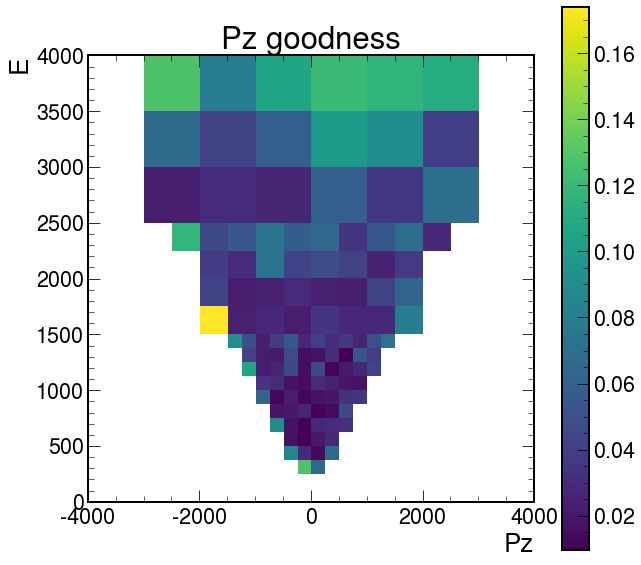

In [47]:
g_matrix_pz = np.zeros((len(g_matrix1_pz[0]/3*8), len(g_matrix1_pz[1])))

widemat2 = np.repeat(g_matrix2_pz, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(g_matrix3_pz, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

g_matrix_pz = np.concatenate([widemat3, widemat2, g_matrix1_pz])

plt.imshow(g_matrix_pz, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0)
plt.title("Pz goodness")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

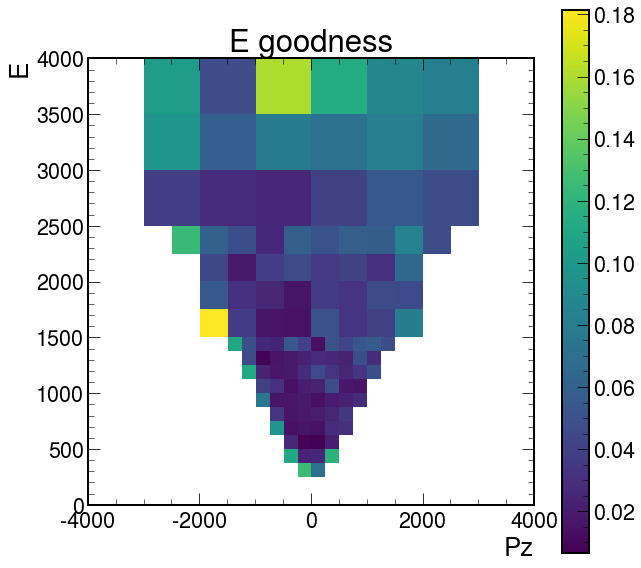

In [46]:
g_matrix_E = np.zeros((len(g_matrix1_E[0]/3*8), len(g_matrix1_E[1])))

widemat2 = np.repeat(g_matrix2_E, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(g_matrix3_E, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

g_matrix_E = np.concatenate([widemat3, widemat2, g_matrix1_E])

plt.imshow(g_matrix_E, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0)
plt.title("E goodness")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

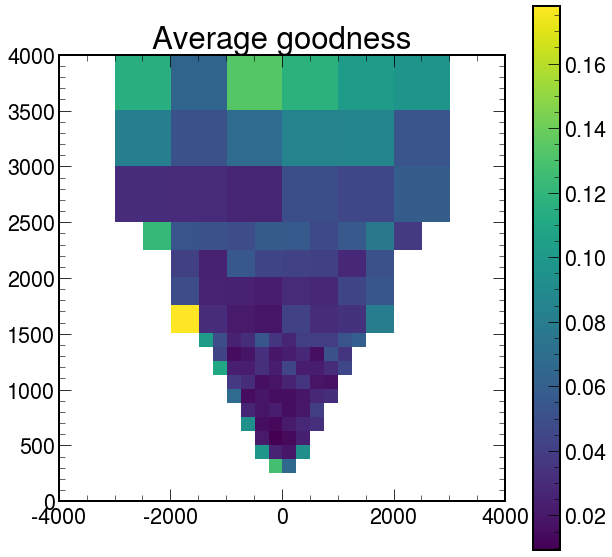

In [26]:
g_matrix_avg = (g_matrix_pz + g_matrix_E)*0.5

plt.imshow(g_matrix_avg, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0)
plt.title("Average goodness")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

### Splitting Dataset: Training and Validation

In [28]:
half = int(len(Y_scaled)/2)
Y_scaled_train = Y_scaled[:half]
Y_val = y_cond[half:]

X_scaled_train = X_scaled[:half]
X_val = X[half:]

In [30]:
nepochs = 50
batch_size = 2048
lr_init = 0.0001
N_training_samples = len(Y_scaled_train)

val_flow = build_flow_gauss(features=2, ntransforms=4, context=2, hidden_mlp=[32], bins=10, autoregressive=True)
val_flow = val_flow.to("cuda")
optimizer = optim.Adam(val_flow.parameters(), lr=lr_init)

X_scaled_train = X_scaled_train.to("cuda")
Y_scaled_train = Y_scaled_train.to("cuda")

for e in trange(0, nepochs, desc="Epoch"):
    
    permutation = torch.randperm(N_training_samples).to("cuda")
    t = trange(0, N_training_samples, batch_size, desc="Batch")
    for i in t:
            
        indices = permutation[i:i+batch_size]
        
        optimizer.zero_grad()

        logp_g =  val_flow(Y_scaled_train[indices]).log_prob(X_scaled_train[indices])

        loss =  - logp_g.mean()
        loss.backward()

        optimizer.step()     

        if i % (batch_size *20) == 0:
            t.set_description(f"{loss.item():.4f}", refresh=True)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

In [31]:
val_flow = val_flow.cpu()

In [33]:
valg_matrix3_pz, valg_matrix3_E = g_matrix(val_flow, Y_val, X_val, seg3_pz, seg3_E)
valg_matrix2_pz, valg_matrix2_E = g_matrix(val_flow, Y_val, X_val, seg2_pz, seg2_E)
valg_matrix1_pz, valg_matrix1_E = g_matrix(val_flow, Y_val, X_val, seg1_pz, seg1_E)


matrix generated.
matrix generated.
matrix generated.


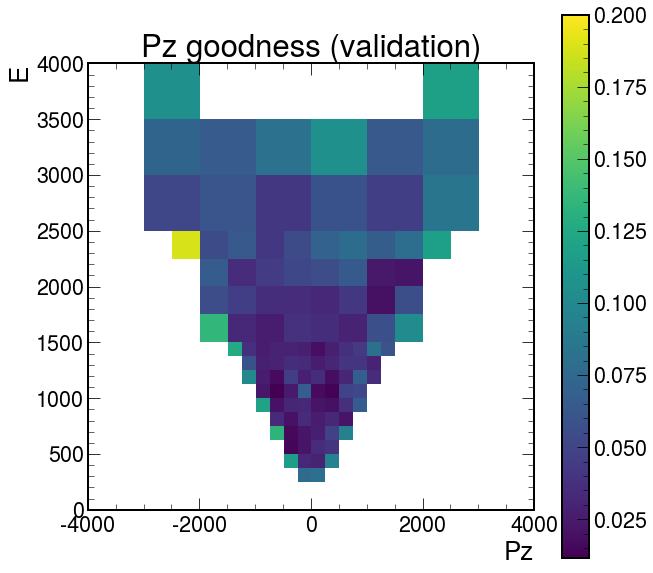

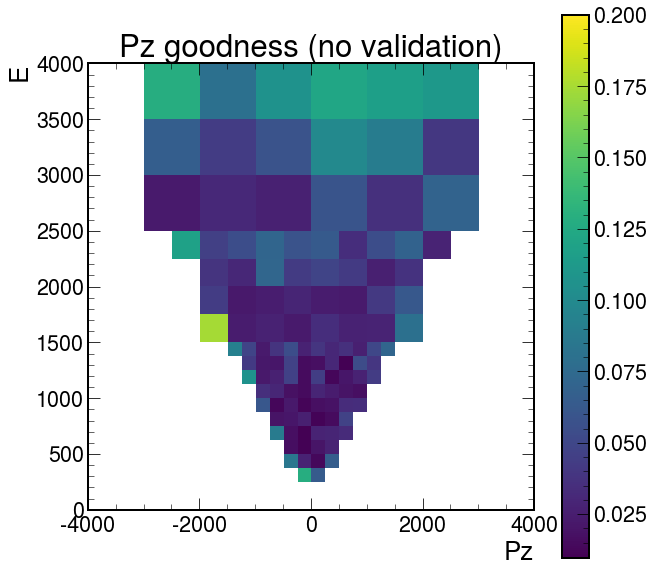

In [49]:
valg_matrix_pz = np.zeros((len(valg_matrix1_pz[0]/3*8), len(valg_matrix1_pz[1])))

widemat2 = np.repeat(valg_matrix2_pz, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(valg_matrix3_pz, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

valg_matrix_pz = np.concatenate([widemat3, widemat2, valg_matrix1_pz])

plt.imshow(valg_matrix_pz, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.2))
plt.title("Pz goodness (validation)")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

plt.imshow(g_matrix_pz, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.2))
plt.title("Pz goodness (no validation)")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

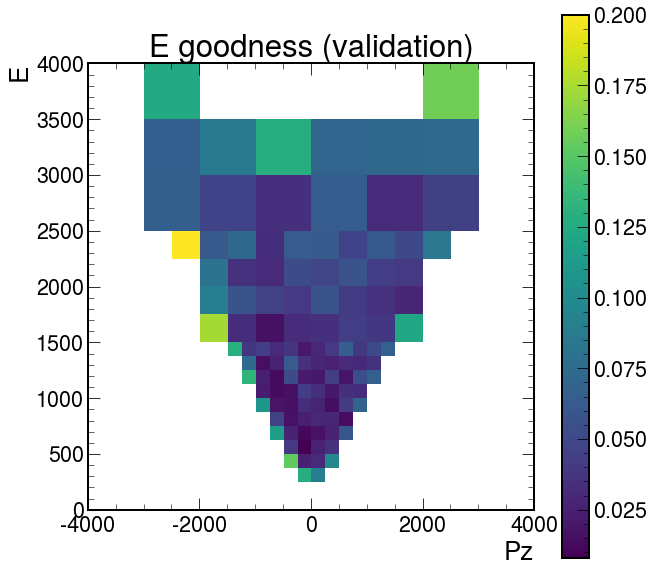

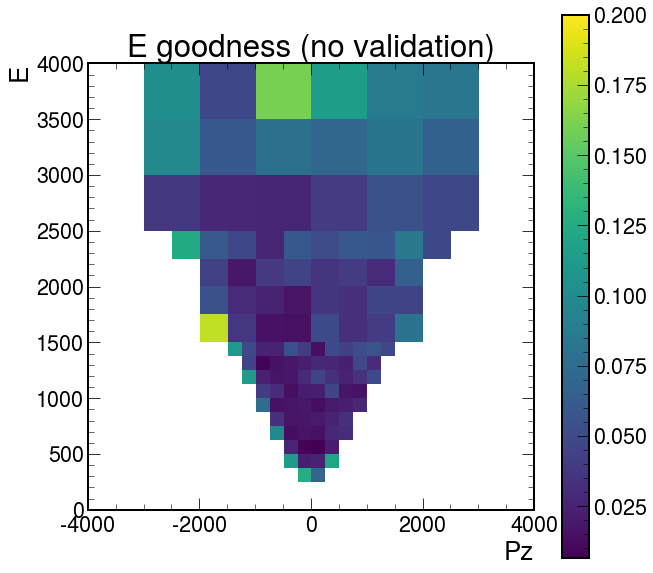

In [48]:

widemat2 = np.repeat(valg_matrix2_E, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(valg_matrix3_E, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

valg_matrix_E = np.concatenate([widemat3, widemat2, valg_matrix1_E])

plt.imshow(valg_matrix_E, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.2))
plt.title("E goodness (validation)")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

plt.imshow(g_matrix_E, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.2))
plt.title("E goodness (no validation)")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

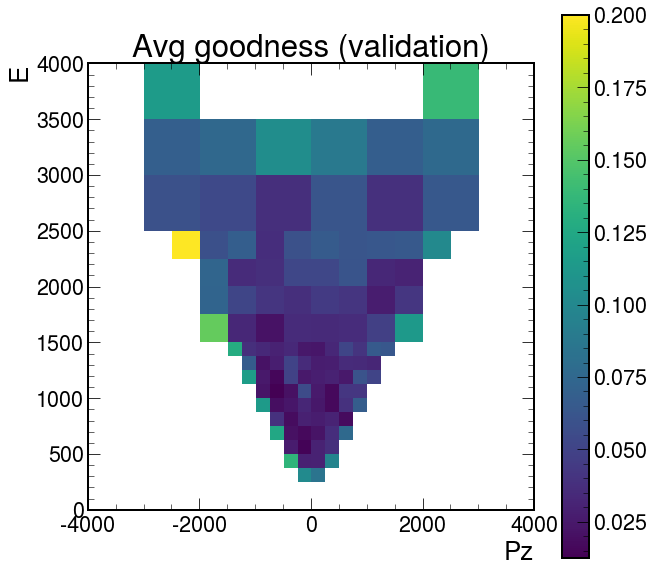

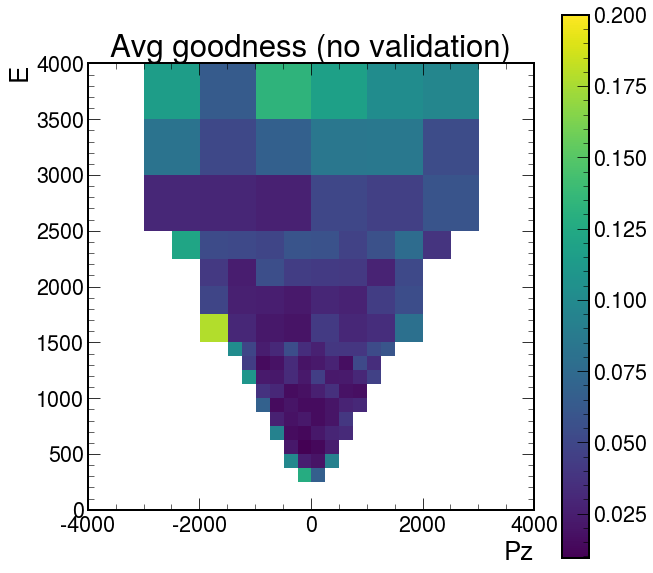

In [50]:
valg_matrix_avg = (valg_matrix_pz + valg_matrix_E)*0.5

plt.imshow(valg_matrix_avg, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.2))
plt.title("Avg goodness (validation)")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

plt.imshow(g_matrix_avg, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.2))
plt.title("Avg goodness (no validation)")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

### Wasserstein distance

In [39]:
def wassergoodness(input_flow, y, x, pz_range, E_range):
    y_select, x_select = select_segments(y, x, pz_range, E_range)
    if y_select.shape[0] < 100:
        return (None, None)
    Y_select_scaled = torch.from_numpy(scaler.transform(y_select)).float()
    X_select_scaled = torch.from_numpy(scaler.transform(x_select)).float()
    out = input_flow(Y_select_scaled).sample((1, )).squeeze(0)
    
    pz_goodness = wasserstein_distance(X_select_scaled[:,0].numpy(), out[:,0].numpy())
    E_goodness = wasserstein_distance(X_select_scaled[:,1].numpy(), out[:,1].numpy())
    
    return (pz_goodness, E_goodness)

def wasserg_matrix(input_flow, y, x, seg_pz, seg_E):
    n_pz = len(seg_pz)-1
    n_E = len(seg_E)-1
    g_matrix_pz = np.zeros((n_E, n_pz))
    g_matrix_E = g_matrix_pz.copy()

    for i in range(n_pz):
        for j in range(n_E):
            pz_goodness, E_goodness = wassergoodness(input_flow, y, x, [seg_pz[i], seg_pz[i+1]], [seg_E[j], seg_E[j+1]])
            g_matrix_pz[n_E-j-1, i] = pz_goodness
            g_matrix_E[n_E-j-1, i] = E_goodness
    print("matrix generated.")        
    return g_matrix_pz, g_matrix_E

In [40]:
wasserg_matrix3_pz, wasserg_matrix3_E = wasserg_matrix(flow, y_cond, X, seg3_pz, seg3_E)
wasserg_matrix2_pz, wasserg_matrix2_E = wasserg_matrix(flow, y_cond, X, seg2_pz, seg2_E)
wasserg_matrix1_pz, wasserg_matrix1_E = wasserg_matrix(flow, y_cond, X, seg1_pz, seg1_E)

matrix generated.
matrix generated.
matrix generated.


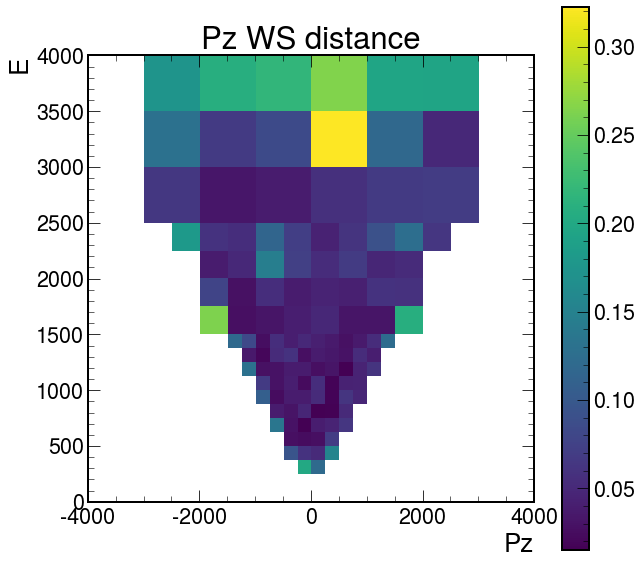

In [51]:
wasserg_matrix_pz = np.zeros((len(wasserg_matrix1_pz[0]/3*8), len(wasserg_matrix1_pz[1])))

widemat2 = np.repeat(wasserg_matrix2_pz, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(wasserg_matrix3_pz, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

wasserg_matrix_pz = np.concatenate([widemat3, widemat2, wasserg_matrix1_pz])

plt.imshow(wasserg_matrix_pz, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0)
plt.title("Pz WS distance")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

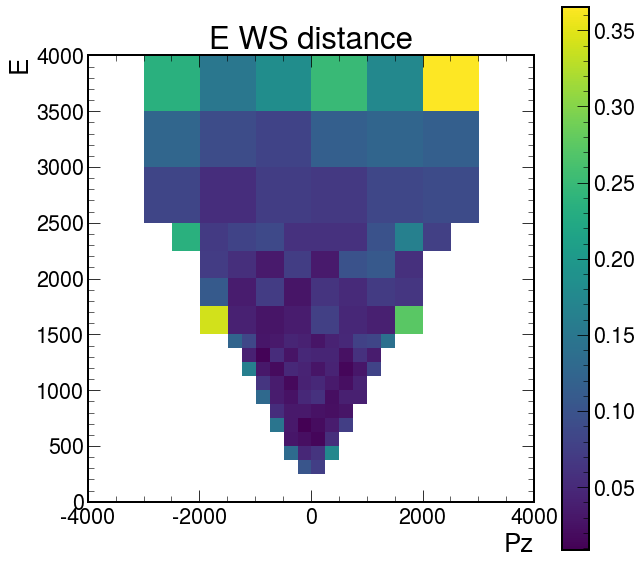

In [52]:
wasserg_matrix_E = np.zeros((len(wasserg_matrix1_E[0]/3*8), len(wasserg_matrix1_E[1])))

widemat2 = np.repeat(wasserg_matrix2_E, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(wasserg_matrix3_E, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

wasserg_matrix_E = np.concatenate([widemat3, widemat2, wasserg_matrix1_E])

plt.imshow(wasserg_matrix_E, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0)
plt.title("E WS distance")
plt.xlabel("Pz"); plt.ylabel("E")
plt.colorbar()
plt.show()

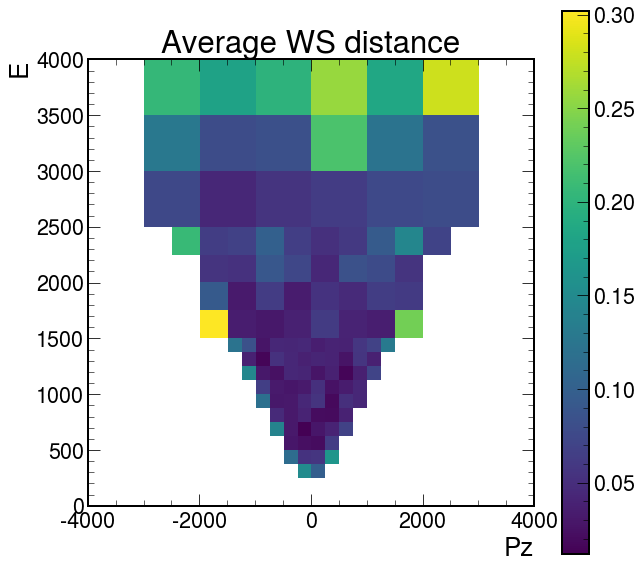

In [53]:
wasserg_matrix_avg = (wasserg_matrix_pz + wasserg_matrix_E)*0.5

plt.imshow(wasserg_matrix_avg, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0)
plt.title("Average WS distance")
plt.xlabel("Pz"); plt.ylabel("E")
plt.colorbar()
plt.show()